# TimeSHAP

#### Import

In [1]:
import numpy as np
import pandas as pd
from typing import Callable, Union
from timeshap.explainer.kernel import TimeShapKernel

from Load_and_Preprocess_Aachen import preprocess_aachen_dataset
from LSTM_Model_Training import load_model_structure_and_weights, plot_predictions_vs_actual, plot_residuals

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import copy

#### Variables

In [ ]:
# Define the file path for the dataset
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat'

# Define the number of test cells to be used
test_cell_count = 3

# Set the global random seed for reproducibility
random_state = 52
np.random.seed(random_state)

# Number of sampels to be used for the SHAP explainer
n_samples = 1000

## Loading and Preprocessing Data

In [3]:
# Load and preprocess Aachen data
preprocessed_full = preprocess_aachen_dataset(
    file_path,
    test_cell_count=3,
    random_state=random_state,
    phase=None,
    log_transform=False
)

# Assign feature splits to LSTM-specific variables
X_train_lstm = preprocessed_full["X_train"]
X_val_lstm   = preprocessed_full["X_val"]
X_test_lstm  = preprocessed_full["X_test"]

# Also extract the target variables
y_train_norm = preprocessed_full["y_train"]
y_val_norm   = preprocessed_full["y_val"]
y_test_norm  = preprocessed_full["y_test"]

# Assign the y_max value
y_max = preprocessed_full["y_max"]

# Print the shapes to verify the assignments
print("  X_train_lstm:", X_train_lstm.shape)
print("  X_val_lstm:  ", X_val_lstm.shape)
print("  X_test_lstm: ", X_test_lstm.shape)
print("  y_train:", y_train_norm.shape)
print("  y_val:  ", y_val_norm.shape)
print("  y_test: ", y_test_norm.shape)

  X_train_lstm: (7190, 272, 1)
  X_val_lstm:   (1798, 272, 1)
  X_test_lstm:  (595, 272, 1)
  y_train: (7190,)
  y_val:   (1798,)
  y_test:  (595,)


## Load model

In [4]:
# Load the model structure and weights from the specified file
model = load_model_structure_and_weights('model_20250131_124416')

# Display the model summary to verify the structure and loaded weights
model

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250131_124416.structure.json
Weights file: Aachen/Models/model_20250131_124416.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
Model loaded from Aachen/Models/model_20250131_124416.structure.json and Aachen/Models/model_20250131_124416.weights.h5


<Sequential name=sequential_2, built=True>

## Test model

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8971e-04 - mae: 0.0180

Test Loss: 0.0009450705256313086
Test MAE: 0.024175753816962242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1029.755249
1        1055.0      1029.259155
2        1050.0      1026.125732
3        1045.0      1021.070496
4        1040.0      1014.818420


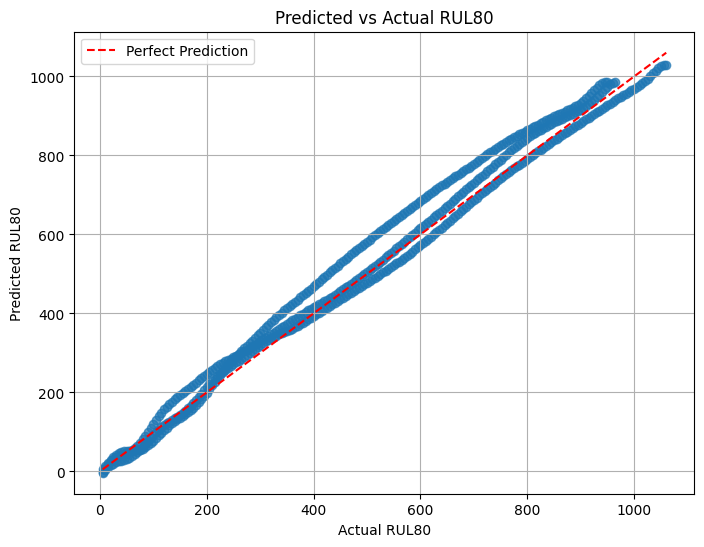

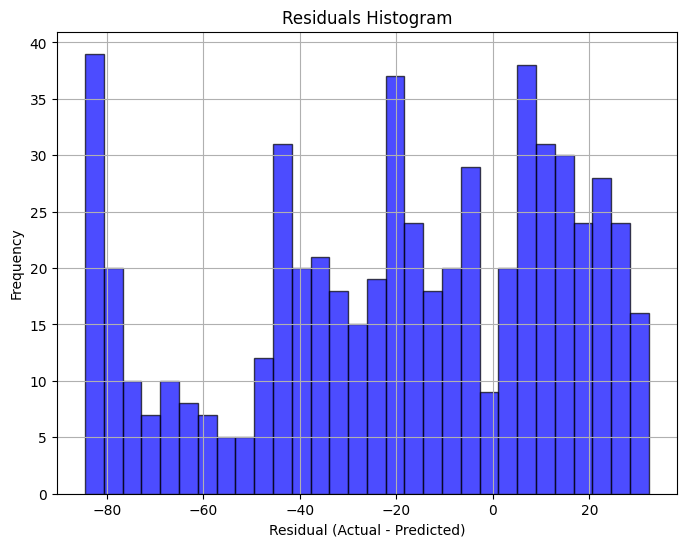

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


In [5]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)

# Print model summary
print(model.summary())

### Test on trimmed data

In [6]:
def evaluate_model_on_trimmed_sequences(model, X_test):
    """
    Evaluates the model on each trimmed sequence from X_test.
    
    Parameters
    ----------
    model : callable
        The model to be evaluated. It should accept a 3-D numpy array of shape (1, seq_len, 1)
        and return a 2-D numpy array (for example, predictions).
    X_test : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1). These sequences are assumed to be padded
        (e.g., with zeros) to a fixed length.
    
    Returns
    -------
    list
        A list of model predictions, one for each trimmed sequence.
    """
    predictions = []
    for i, seq in enumerate(X_test):
        # Compute a mask for the current sequence: True for timesteps where not all features are zero.
        mask = ~np.all(seq == 0, axis=-1)
        # Trim the sequence using the mask.
        trimmed_seq = seq[mask, :]
        # Add the batch dimension so that the sequence has shape (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]
        
        # Evaluate the model on the trimmed sequence.
        pred = model(trimmed_seq)
        predictions.append(pred)
        
        # Optionally print the shape for debugging.
        print(f"Sequence {i}: original length = {seq.shape[0]}, trimmed length = {trimmed_seq.shape[1]}")
    
    # Convert the list of predictions to a numpy array.
    predictions = np.array(predictions).squeeze()  # Remove the batch dimension.
    return predictions

Sequence 0: original length = 272, trimmed length = 21
Sequence 1: original length = 272, trimmed length = 22
Sequence 2: original length = 272, trimmed length = 23
Sequence 3: original length = 272, trimmed length = 24
Sequence 4: original length = 272, trimmed length = 25
Sequence 5: original length = 272, trimmed length = 26
Sequence 6: original length = 272, trimmed length = 27
Sequence 7: original length = 272, trimmed length = 28
Sequence 8: original length = 272, trimmed length = 29
Sequence 9: original length = 272, trimmed length = 30
Sequence 10: original length = 272, trimmed length = 31
Sequence 11: original length = 272, trimmed length = 32
Sequence 12: original length = 272, trimmed length = 33
Sequence 13: original length = 272, trimmed length = 34
Sequence 14: original length = 272, trimmed length = 35
Sequence 15: original length = 272, trimmed length = 36
Sequence 16: original length = 272, trimmed length = 37
Sequence 17: original length = 272, trimmed length = 38
Se

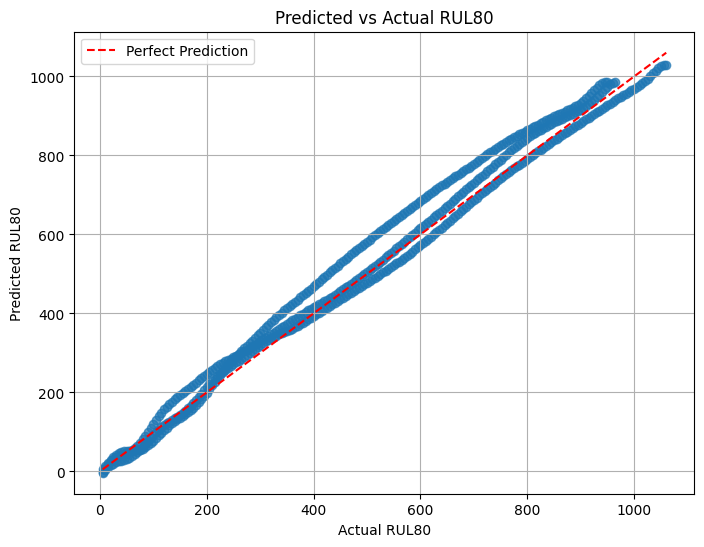

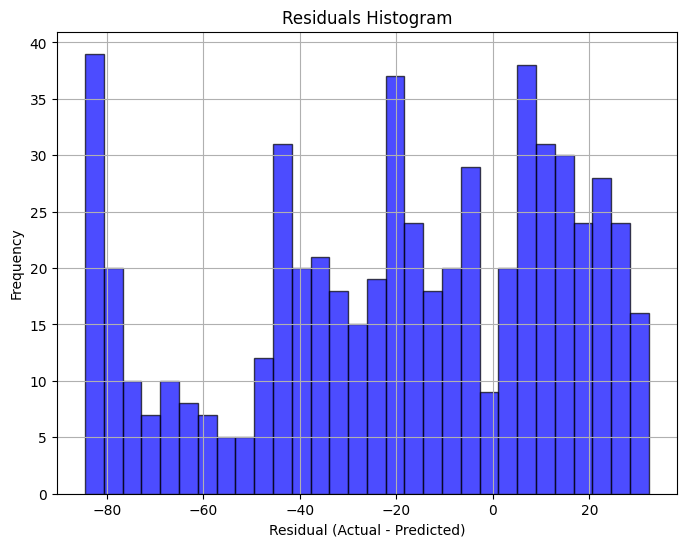

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         1,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,805 (135.96 KB)

 Trainable params: 11,601 (45.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,204 (90.64 KB)

None


In [7]:
# Make predictions on the test set
y_pred_trimmed = evaluate_model_on_trimmed_sequences(model, X_test_lstm)


# Rescale predictions and test data back to the original range
y_pred_trimmed_rescaled = y_pred_trimmed.flatten() * y_max
y_test_rescaled = y_test_norm * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_trimmed_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_trimmed_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_trimmed_rescaled)

# Print model summary
print(model.summary())

### Full and Trimmed Predictions

In [8]:
# Plot the original and trimmed predictions in the same plot
fig = go.Figure()

# Add the original predictions
fig.add_trace(go.Scatter(
    x=np.arange(len(y_pred_rescaled)),
    y=y_pred_rescaled,
    mode="lines",
    name="Full Predictions"
))

# Add the trimmed predictions
fig.add_trace(go.Scatter(
    x=np.arange(len(y_pred_trimmed_rescaled)),
    y=y_pred_trimmed_rescaled,
    mode="lines",
    name="Trimmed Predictions"
))

# Update the layout
fig.update_layout(
    title="Full and Trimmed Predictions",
    xaxis_title="Sample Index",
    yaxis_title="Predicted RUL80"
)


The predictions from model are approximate the same both when the data is trimmed and untrimmed

## TimeSHAP

### Model entry point

In [9]:
# Define the model prediction function
f = lambda x: model.predict(x)

### Baseline event

In [10]:
def avg_rul(X_train_lstm):
    # Reshape the array to 2D for easier processing
    X_train_lstm_2d = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])
    
    # Create a mask to exclude rows that are all zeros
    non_zero_mask = np.any(X_train_lstm_2d != 0, axis=1)
    
    # Calculate the mean of the non-zero rows
    avg = np.mean(X_train_lstm_2d[non_zero_mask])
    
    # Return the average as a NumPy array with shape (1, 1)
    return np.array([[avg]])

average_event = avg_rul(X_train_lstm)

average_event

array([[0.6724684]], dtype=float32)

### Local explanations

#### Helper functions

In [11]:
def get_random_sequence(X_test, index: int = None, trimmed: bool = False) -> np.ndarray:
    """
    Selects a sequence from the test set, with an option to trim out all timesteps
    that are entirely zeros.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test set with shape [n_samples, seq_len, n_features].
    index : int, optional
        Specific index to select a sequence. If None, a random index is selected.
    trimmed : bool, optional
        If True, returns the sequence with all-zero timesteps removed.
        If False, returns the full sequence.
    
    Returns
    -------
    np.ndarray
        If trimmed is False: a sequence with shape [1, seq_len, n_features].
        If trimmed is True: a sequence with shape [1, x, n_features],
        where x is the number of non-zero timesteps.
    """
    if index is None:
        index = np.random.randint(0, len(X_test))
    
    # Select the sequence and add a batch dimension (resulting shape: [1, seq_len, n_features])
    sequence = X_test[index][np.newaxis, :, :]
    print("Selected index:", index)
    
    if trimmed:
        # Create a mask for timesteps that are not all zeros (for the first and only sample)
        mask = ~np.all(sequence[0] == 0, axis=-1)
        # Apply the mask along the time axis
        sequence = sequence[:, mask, :]
        print("Trimmed sequence shape:", sequence.shape)
    else:
        print("Sequence shape:", sequence.shape)
    
    return sequence

In [12]:
def plot_event_explanation(event_explanation: pd.DataFrame, height: int = 600, width: int = 1000) -> go.Figure:
    """
    Generates a dual-axis plot showing event-level explanations.
    
    Parameters
    ----------
    event_explanation : pd.DataFrame
        DataFrame with columns ['Event', 'Shapley Value', 'Sequence Value'].
        The 'Event' column should contain numeric labels as strings.
    height : int, optional
        Plot height (default is 600).
    width : int, optional
        Plot width (default is 1000).
        
    Returns
    -------
    go.Figure
        A Plotly Figure with a dual-axis plot.
    """
    
    # Create the dual-axis plot using Plotly.
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add the Shapley Value trace (primary y-axis).
    fig.add_trace(
        go.Scatter(
            x=event_explanation.index,
            y=event_explanation["Shapley Value"],
            mode='lines',
            name='Shapley Value'
        ),
        secondary_y=False
    )
    
    # Add the Sequence Value trace (secondary y-axis).
    fig.add_trace(
        go.Scatter(
            x=event_explanation.index,
            y=event_explanation["Sequence Value"],
            mode='lines',
            name='Sequence Value'
        ),
        secondary_y=True
    )
    
    # Update layout and axis titles.
    fig.update_layout(
        title="Event Explanation",
        xaxis_title="Event Number",
        height=height,
        width=width
    )
    fig.update_yaxes(title_text="Shapley Value", secondary_y=False)
    fig.update_yaxes(title_text="Sequence Value", secondary_y=True)
    
    return fig


In [13]:
def local_event_explainer(
    f: Callable[[np.ndarray], np.ndarray],
    data: np.ndarray,
    baseline: Union[pd.DataFrame, np.ndarray],
    pruned_idx: int,
    random_seed: int = 42,
    nsamples: int = 1000
) -> pd.DataFrame:
    """
    Computes event-level (cell-level) explanations for a single-feature model using
    the event mode of TimeShapKernel.
    
    Each time step (after the pruned index) is treated as an event.
    
    Parameters
    ----------
    f : Callable[[np.ndarray], np.ndarray]
        Model function that accepts a 3-D numpy array of shape (1, seq_len, 1)
        and returns a 2-D numpy array.
    data : np.ndarray
        Input instance to be explained, with shape (n_samples, seq_len, 1).
    baseline : Union[pd.DataFrame, np.ndarray]
        Baseline data (e.g., an average event) used for integrating out features.
    pruned_idx : int
        The index at which the sequence is pruned (e.g. 0 if no pruning is applied).
    random_seed : int, optional
        Random seed for reproducibility (default is 42).
    nsamples : int, optional
        Number of samples for the kernel estimation (default is 1000).
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Event', 'Shapley Value', 'Sequence Value']
        listing the explanation for each event (time step).
    """
    # Instantiate the TimeShapKernel in event mode.
    explainer = TimeShapKernel(f, baseline, random_seed, mode="event")
    
    # Compute Shapley values for the instance.
    shap_values_arr = explainer.shap_values(data, pruning_idx=pruned_idx, nsamples=nsamples)
    
    # The kernel computes the Shapley values in reverse order (from last to first).
    # Reverse the array to restore natural (chronological) order.
    shap_values_arr_reversed = shap_values_arr[::-1]
    
    # Extract the sequence values from the input data.
    sequence_values = data[0, pruned_idx:, 0]
    
    # Build the explanation DataFrame.
    explanation_df = pd.DataFrame({
        "Shapley Value": shap_values_arr_reversed,
        "Sequence Value": sequence_values
    })
    
    return explanation_df


### Local Event-Level Explanation

#### For index 201

In [83]:
# Get a random trimmed sequence from the test set.
trimmed_sequence = get_random_sequence(X_test_lstm, 150, trimmed=True)

# Compute the local event explanation for the trimmed sequence.
event_explanation = local_event_explainer(f, trimmed_sequence, average_event, pruned_idx=0, nsamples=n_samples)

# Plot the event explanation.
plot_event_explanation(event_explanation)

Selected index: 150
Trimmed sequence shape: (1, 171, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [64]:
# Get a random untrimmed sequence from the test set.
full_sequence = get_random_sequence(X_test_lstm, 205, trimmed=False)

# Compute the local event explanation for the full sequence.
full_event_explanation = local_event_explainer(f, full_sequence, average_event, pruned_idx=0, nsamples=n_samples)

# Plot the event explanation.
plot_event_explanation(full_event_explanation)

Selected index: 205
Sequence shape: (1, 272, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Global explanations

#### Helper functions

In [ ]:
def event_explain_all(f: callable,
                      data: np.ndarray,
                      baseline: np.ndarray = None,
                      random_seed: int = 42,
                      nsamples: int = 1000,
                      verbose: bool = False) -> pd.DataFrame:
    """
    Calculates event-level explanations for all sequences in the provided numpy array,
    after trimming out any zero-padded timesteps.
    
    Assumes that:
      - `data` is a NumPy array of shape (n_samples, seq_len, 1)
      - The model uses only one feature.
      - A fixed pruning index of 0 is used (i.e. no pruning).
    
    Parameters
    ----------
    f : callable
        The model function that accepts a 3-D numpy array (n_samples, seq_len, 1)
        and returns a 2-D numpy array (e.g., predictions).
    data : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1).
    baseline : np.ndarray, optional
        Baseline data (e.g., an average event or sequence) with shape (seq_len, 1)
        or (1, seq_len, 1).
    random_seed : int, optional
        Random seed for reproducibility (default is 42).
    nsamples : int, optional
        Number of samples for the kernel estimation (default is 10000).
    verbose : bool, optional
        If True, prints additional debugging information.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with aggregated event-level explanations.
        The columns are:
          - 'Event Number': Numeric index of the event (time step)
          - 'Average Shapley Value': Averaged Shapley value for that event index across sequences.
    """
    ret_event_data = []
    # Fixed pruning index (no pruning)
    pruning_idx = 0

    # Loop over each sequence in the data array
    for i, sequence in enumerate(data):
        # Ensure sequence is float64
        sequence = sequence.astype(np.float64)
        
        # Compute mask: True for timesteps where not all features are zero.
        mask = ~np.all(sequence == 0, axis=-1)
        # Trim the sequence using its own mask (resulting shape: (trimmed_seq_len, 1))
        trimmed_seq = sequence[mask, :]
        # Add batch dimension so that shape becomes (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]
        
        # Compute the event-level explanation for the current trimmed sequence.
        # local_event_explainer is assumed to return a DataFrame with an index that corresponds
        # to the event number and columns ['Shapley Value', 'Sequence Value'].
        event_data = local_event_explainer(f, trimmed_seq, baseline, pruning_idx, random_seed, nsamples)
        
        # Reset the index to turn it into a column named "Event Number"
        event_data = event_data.reset_index().rename(columns={'index': 'Event Number'})
        
        if verbose:
            print(f"Sequence {i}: original length = {sequence.shape[0]}, trimmed length = {trimmed_seq.shape[1]}, "
                  f"event indices: {event_data['Event Number'].tolist()}")
        
        ret_event_data.append(event_data)
    
    # Concatenate all individual explanation DataFrames.
    combined_df = pd.concat(ret_event_data, ignore_index=True)
    
    # Group by 'Event Number' and compute the mean of the Shapley values.
    aggregated_df = combined_df.groupby('Event Number')['Shapley Value'].mean().reset_index()
    aggregated_df.rename(columns={'Shapley Value': 'Average Shapley Value'}, inplace=True)
    
    return aggregated_df

In [21]:
def plot_global_event(aggregated_df: pd.DataFrame,
                      plot_parameters: dict = None) -> go.Figure:
    """
    Plots global event explanations using Plotly.

    Parameters
    ----------
    aggregated_df : pd.DataFrame
        DataFrame with columns ['Event Number', 'Average Shapley Value'].
    plot_parameters : dict, optional
        Dictionary with optional plot parameters:
            - 'height': height of the plot (default 600)
            - 'width': width of the plot (default 1000)
            - 'axis_lims': y-axis domain for Average Shapley Value (default None)
            - 'event_limit': minimum event number to include (default: None, include all)

    Returns
    -------
    go.Figure
        A Plotly Figure representing the global event explanations.
    """
    # Make a copy so we don't modify the original DataFrame
    data = copy.deepcopy(aggregated_df)

    # Set default plot parameters if not provided
    if plot_parameters is None:
        plot_parameters = {}
    height = plot_parameters.get('height', 600)
    width = plot_parameters.get('width', 1000)
    axis_lims = plot_parameters.get('axis_lims', None)
    event_limit = plot_parameters.get('event_limit', None)

    # Optionally filter out events below a certain event number
    if event_limit is not None:
        data = data[data['Event Number'] >= event_limit]

    # For plotting, add 1 to the event number so that, e.g., event 0 becomes 1
    data['Plot Event Number'] = data['Event Number'] + 1

    # Create the Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=data['Plot Event Number'],
        y=data['Average Shapley Value'],
        mode='lines+markers',
        marker=dict(size=8, color="#48caaa"),
        line=dict(width=2),
        name='Average Shapley Value'
    ))

    fig.update_layout(
        title="Global Event Explanation",
        xaxis_title="Event Number",
        yaxis_title="Average Shapley Value",
        width=width,
        height=height,
        yaxis=dict(range=axis_lims)
    )

    return fig

In [22]:
event_data = event_explain_all(
    f=f,
    data=X_test_lstm,
    baseline=average_event,
    random_seed=random_state,
    nsamples=n_samples,
    verbose=True
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 2: original length = 272, trimmed length = 23, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 3: original length = 272, trimmed length = 24, event indices: [0, 1, 2, 3, 4, 5, 

In [27]:
global_event_chart = plot_global_event(event_data)

global_event_chart

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.

In [28]:
def plot_normalized_explanation(aggregated_df: pd.DataFrame,
                                width: int = 500,
                                height: int = 300,
                                title: str = 'Normalized Event Explanation') -> go.Figure:
    """
    Plots the normalized event-level explanations using Plotly.
    
    The DataFrame is expected to have the following columns:
      - 'Bin Center': The center of the relative bin (normalized position between 0 and 1).
      - 'Mean Shapley Value': The mean Shapley value for events in that bin.
      - 'Median Shapley Value': The median Shapley value for events in that bin.
      - 'Count': The number of events in that bin (optional for tooltip).
    
    Parameters
    ----------
    aggregated_df : pd.DataFrame
        Aggregated DataFrame with normalized event explanations.
    width : int, optional
        Width of the plot (default is 500).
    height : int, optional
        Height of the plot (default is 300).
    title : str, optional
        Title of the plot (default is 'Normalized Event Explanation').
        
    Returns
    -------
    go.Figure
        A Plotly Figure object representing the normalized event-level explanations.
    """
    # Create the Plotly figure
    fig = go.Figure()
    
    # Add a trace for the mean Shapley values
    fig.add_trace(go.Scatter(
        x=aggregated_df['Bin Center'],
        y=aggregated_df['Mean Shapley Value'],
        mode='lines+markers',
        name='Mean Shapley Value',
        marker=dict(color='blue'),
        line=dict(color='blue')
    ))
    
    # Add a trace for the median Shapley values
    fig.add_trace(go.Scatter(
        x=aggregated_df['Bin Center'],
        y=aggregated_df['Median Shapley Value'],
        mode='lines+markers',
        name='Median Shapley Value',
        marker=dict(color='red'),
        line=dict(color='red')
    ))
    
    # Update the layout with the given parameters
    fig.update_layout(
        title=title,
        xaxis_title='Relative Position (Bin Center)',
        yaxis_title='Shapley Value',
        width=width,
        height=height
    )
    
    return fig

In [76]:
def event_explain_all_normalized(f: callable,
                                 data: np.ndarray,
                                 baseline: np.ndarray = None,
                                 random_seed: int = 42,
                                 nsamples: int = 1000,
                                 num_bins: int = 20,
                                 verbose: bool = False) -> pd.DataFrame:
    """
    Calculates event-level explanations for all sequences in the provided numpy array,
    after trimming out any zero-padded timesteps, and aggregates the explanations based
    on the relative position of the event within the trimmed sequence.
    
    The relative position is computed as:
        Relative Position = (Event Index) / (L - 1)
    where L is the length of the trimmed sequence.
    
    Parameters
    ----------
    f : callable
        The model function that accepts a 3-D numpy array of shape (n_samples, seq_len, 1)
        and returns a 2-D numpy array (e.g., predictions).
    data : np.ndarray
        Test sequences with shape (n_samples, seq_len, 1).
    baseline : np.ndarray, optional
        Baseline data (e.g., an average event or sequence) with shape (seq_len, 1)
        or (1, seq_len, 1).
    random_seed : int, optional
        Random seed for reproducibility (default is 42).
    nsamples : int, optional
        Number of samples for the kernel estimation (default is 10000).
    num_bins : int, optional
        Number of bins to use when aggregating relative positions (default is 20).
    verbose : bool, optional
        If True, prints additional debugging information.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with aggregated event-level explanations on a relative scale.
        The columns include:
            - 'Relative Bin': The bin index for the normalized event position.
            - 'Mean Shapley Value': Mean Shapley value for events in that bin.
            - 'Median Shapley Value': Median Shapley value for events in that bin.
            - 'Count': Number of events in that bin.
            - 'Bin Center': The center of the relative bin (for plotting).
    """
    ret_event_data = []
    pruning_idx = 0  # Fixed, no pruning

    # Process each sequence in the dataset
    for i, sequence in enumerate(data):
        # Convert sequence to float64 for consistency.
        sequence = sequence.astype(np.float64)
        # Create a mask for timesteps that are not all zeros.
        mask = ~np.all(sequence == 0, axis=-1)
        # Trim the sequence using its own mask.
        trimmed_seq = sequence[mask, :]
        # Add the batch dimension so that the shape becomes (1, trimmed_seq_len, 1)
        trimmed_seq = trimmed_seq[np.newaxis, :, :]
        
        # Compute the event-level explanation for the current trimmed sequence.
        # Here we call the local_event_explainer (assumed to return a DataFrame with an index that
        # represents the event number and columns ['Shapley Value', 'Sequence Value']).
        event_data = local_event_explainer(f, trimmed_seq, baseline, pruning_idx, random_seed, nsamples)
        
        # Reset the index to turn it into a column named "Event Number"
        event_data = event_data.reset_index().rename(columns={'index': 'Event Number'})
        
        # Compute the relative position for each event.
        L = trimmed_seq.shape[1]
        if L > 1:
            event_data['Relative Position'] = event_data['Event Number'] / (L - 1)
        else:
            event_data['Relative Position'] = 0.0
        
        if verbose:
            print(f"Sequence {i}: original length = {sequence.shape[0]}, trimmed length = {L}, "
                  f"event indices: {event_data['Event Number'].tolist()}, "
                  f"relative positions: {event_data['Relative Position'].tolist()}")
        
        ret_event_data.append(event_data)
    
    # Combine explanations from all sequences.
    combined_df = pd.concat(ret_event_data, ignore_index=True)
    
    # Bin the relative positions into 'num_bins' equal bins in the range [0, 1]
    bins = np.linspace(0, 1, num_bins + 1)
    combined_df['Relative Bin'] = pd.cut(combined_df['Relative Position'], bins=bins, include_lowest=True, labels=False)
    
    # Aggregate the Shapley values by these relative bins.
    aggregated_df = combined_df.groupby('Relative Bin')['Shapley Value'].agg(['mean', 'median', 'count']).reset_index()
    aggregated_df.rename(columns={'mean': 'Mean Shapley Value',
                                  'median': 'Median Shapley Value',
                                  'count': 'Count'}, inplace=True)
    
    # Compute the center of each bin for plotting purposes.
    bin_centers = (bins[:-1] + bins[1:]) / 2
    aggregated_df['Bin Center'] = aggregated_df['Relative Bin'].apply(lambda x: bin_centers[int(x)])
    
    return aggregated_df

### Normalized global events

In [30]:
normalized_events = event_explain_all_normalized(
    f=f,
    data=X_test_lstm,
    baseline=average_event,
    random_seed=random_state,
    nsamples=1000,
    num_bins=30,
    verbose=True
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], relative positions: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], relative positions: [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 

In [31]:
fig = plot_normalized_explanation(
    normalized_events,
    width=1000,
    height=600,
    title='Normalized Explanation'
)

fig.show()

### Coarse view with only 10 bins (insted of 30)  

In [65]:
normalized_events = event_explain_all_normalized(
    f=f,
    data=X_test_lstm,
    baseline=average_event,
    random_seed=random_state,
    nsamples=1000,
    num_bins=10,
    verbose=True
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], relative positions: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], relative positions: [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0

In [67]:
fig = plot_normalized_explanation(
    normalized_events,
    width=1000,
    height=600,
    title='Normalized Explanation'
)

fig.show()

### Thougts on the results

The model appears to be most focused on the last values of the sequence
